In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Define the TripAdvisor URL for hotels in New York
url = "https://www.tripadvisor.in/SmartDeals-g297586-Hyderabad_Hyderabad_District_Telangana-Hotel-Deals.html"

# Send a request to TripAdvisor (set User-Agent to avoid blocking)
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)

# Parse the page with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")

# Find all hotel listings
hotels = soup.find_all("div", class_="listing_title")

# Extract hotel names & URLs
hotel_data = []
for hotel in hotels:
    name = hotel.text.strip()
    link = "https://www.tripadvisor.com" + hotel.a["href"] if hotel.a else "Not Available"

    hotel_data.append({"Hotel Name": name, "Hotel URL": link})

# Convert to DataFrame
df_Hotels = pd.DataFrame(Hotel_data)

# Find all Resturant listings
Resturants = soup.find_all("div", class_="listing_title")

# Extract Resturant names & URLs
Resturant_data = []
for Resturant in Resturants:
    name = Resturant.text.strip()
    link = "https://www.tripadvisor.com" + Resturant.a["href"] if Resturant.a else "Not Available"

    Resturant_data.append({"Resturant Name": name, "Resturant URL": link})

# Convert to DataFrame
df_Resturants = pd.DataFrame(Resturant_data)

# Find all Flight listings
Resturants = soup.find_all("div", class_="listing_title")

# Extract Flight names & URLs
df_Flight_data = []
for Resturant in df_Flights:
    name = Flight.text.strip()
    link = "https://www.tripadvisor.com" + df_Flight.a["href"] if df_Flight.a else "Not Available"

    df_Flight_data.append({"df_Flight Name": name, "df_Flight URL": link})

# Convert to DataFrame
df_df_Flights = pd.DataFrame(df_Flight_data)

print("Data Scraped")


Data Scraped


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Load the expanded dataset
file_path = "/content/hyderabad_travel_dataset_realistic.csv"
df = pd.read_csv(file_path)


In [ ]:
# Define numerical and categorical columns
num_features = ["Hotel Price", "Flight Price", "Restaurant Price"]
cat_features = ["Hotel Name", "Restaurant Name", "Airline"]


In [ ]:
# Normalize numerical price data
scaler = MinMaxScaler()
df[num_features] = scaler.fit_transform(df[num_features])

In [ ]:
# Encode categorical data using Label Encoding
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store for future use

In [ ]:
# Define target variable: Total Cost
df["Total Cost"] = df["Hotel Price"] + df["Flight Price"] + df["Restaurant Price"]

In [ ]:
# Split into training and testing sets
X = df[num_features + cat_features]  # Features
y = df["Total Cost"]  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train the XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=6)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f" Model Trained! \nMean Absolute Error: {mae:.4f} \nR² Score: {r2:.4f}")

 Model Trained! 
Mean Absolute Error: 0.0889 
R² Score: 0.9383


In [ ]:
# NLP Model for Review-Based Recommendations
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["Review"])

In [ ]:
def recommend_within_budget(df, user_budget, model, scaler, user_prompt):
    # Predict total cost
    df["Predicted Cost"] = model.predict(df[num_features + cat_features])
    df["Predicted Cost"] = scaler.inverse_transform(
        np.column_stack((df["Predicted Cost"], np.zeros((df.shape[0], 2))))
    )[:, 0]

    # Filter options within budget
    filtered_df = df[df["Predicted Cost"] <= user_budget].copy()
    if filtered_df.empty:
        return "No options available within this budget. Try increasing the budget."

    # Compute NLP similarity only for filtered hotels
    filtered_tfidf_matrix = tfidf_vectorizer.transform(filtered_df["Review"])
    user_tfidf = tfidf_vectorizer.transform([user_prompt])
    similarity_scores = cosine_similarity(user_tfidf, filtered_tfidf_matrix)[0]

    # Assign similarity scores and sort by relevance
    filtered_df["Similarity"] = similarity_scores
    filtered_df = filtered_df.sort_values(by="Similarity", ascending=False)

    return filtered_df[["Hotel Name", "Restaurant Name", "Airline", "Hotel Price", "Flight Price", "Restaurant Price", "Predicted Cost", "Similarity"]]


In [ ]:
# Example Usage
user_budget = 15000
user_prompt = "Looking for a clean and friendly hotel with great service."
recommendations = recommend_within_budget(df, user_budget, model, scaler, user_prompt)
print("Travel Recommendations Within Budget:")
print(recommendations)


Travel Recommendations Within Budget:
     Hotel Name  Restaurant Name  Airline  Hotel Price  Flight Price  \
176           2                6        0     0.035356      0.552827   
149           0                4        1     0.610835      0.076565   
25            9                3        2     0.008691      0.351971   
139           0                4        1     0.270694      0.175167   
131           1                0        0     0.273310      0.205768   
119           0                4        1     0.172306      0.101750   
117           6                5        3     0.726605      0.188012   
172           8                2        3     0.732343      0.154640   
141           1                0        0     0.031812      0.346052   
118           4                1        4     0.060586      0.395164   
0             7                8        2     0.226563      0.340511   
195           9                3        2     0.122606      0.238887   
20            7           

In [ ]:
# Function to decode categorical values safely
def decode_label(column, value):
    if isinstance(value, int):  # Decode only if it's encoded as an integer
        return label_encoders[column].inverse_transform([value])[0]
    return value  # If it's already a string, return as is

# Reverse label encoding only if needed
best_match["Hotel Name"] = decode_label("Hotel Name", best_match["Hotel Name"])
best_match["Restaurant Name"] = decode_label("Restaurant Name", best_match["Restaurant Name"])
best_match["Airline"] = decode_label("Airline", best_match["Airline"])

# Print the final recommendation
print(f"✅ Best Travel Option Based on Your Preference:")
print(f"🏨 Hotel: {best_match['Hotel Name']}")
print(f"🍽️ Restaurant: {best_match['Restaurant Name']}")
print(f"✈️ Airline: {best_match['Airline']}")
print(f"💰 Total Predicted Price: ₹{best_match['Predicted Cost']:.2f}")


✅ Best Travel Option Based on Your Preference:
🏨 Hotel: Lemon Tree Premier
🍽️ Restaurant: Minerva Coffee Shop
✈️ Airline: Air India
💰 Total Predicted Price: ₹10284.63


<ipython-input-57-51f4eb4c8d56>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_match["Hotel Name"] = decode_label("Hotel Name", best_match["Hotel Name"])
<ipython-input-57-51f4eb4c8d56>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_match["Restaurant Name"] = decode_label("Restaurant Name", best_match["Restaurant Name"])
<ipython-input-57-51f4eb4c8d56>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_match["Airline"

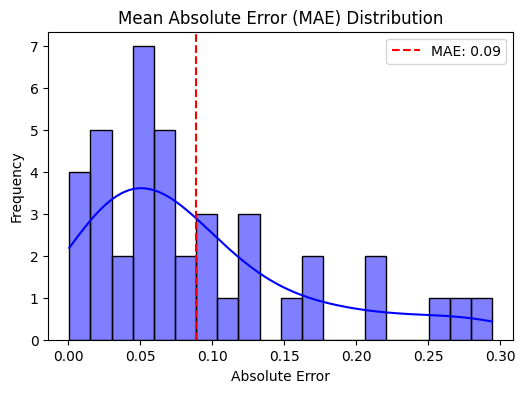

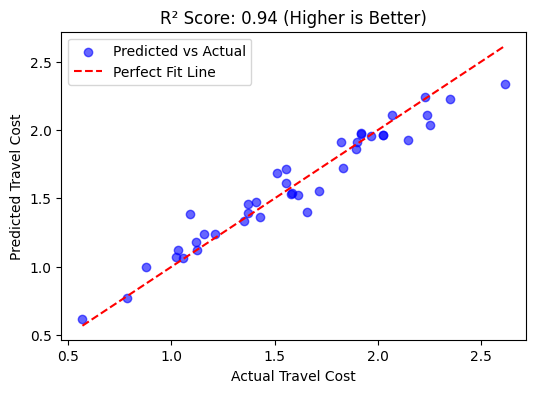

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 📊 Plot 1: MAE Representation
plt.figure(figsize=(6, 4))
sns.histplot(np.abs(y_test - y_pred), bins=20, kde=True, color="blue")
plt.axvline(mae, color="red", linestyle="dashed", label=f"MAE: {mae:.2f}")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Mean Absolute Error (MAE) Distribution")
plt.legend()
plt.show()

# 📊 Plot 2: R² Score Representation
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, color="blue", alpha=0.6, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="dashed", label="Perfect Fit Line")
plt.xlabel("Actual Travel Cost")
plt.ylabel("Predicted Travel Cost")
plt.title(f"R² Score: {r2:.2f} (Higher is Better)")
plt.legend()
plt.show()


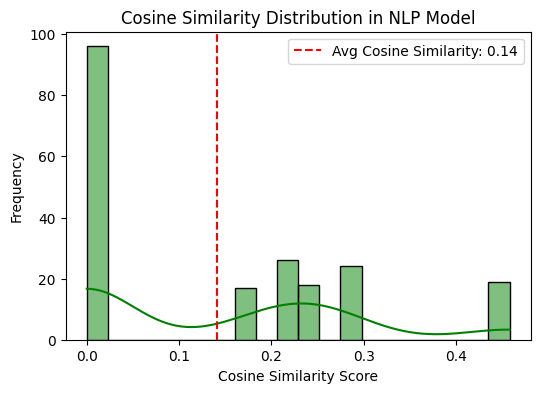

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset (replace with actual file path)
df = pd.read_csv("hyderabad_travel_dataset_realistic.csv")

# Extract hotel reviews
reviews = df["Review"].astype(str).tolist()

# Example user query
user_query = ["Looking for a clean and comfortable hotel with excellent service"]

# Convert text data into numerical form using TF-IDF
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(reviews)
query_vector = vectorizer.transform(user_query)

# Compute Cosine Similarity scores
similarity_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()

# 📊 Plot: Cosine Similarity Distribution
plt.figure(figsize=(6, 4))
sns.histplot(similarity_scores, bins=20, kde=True, color="green")
plt.axvline(np.mean(similarity_scores), color="red", linestyle="dashed", label=f"Avg Cosine Similarity: {np.mean(similarity_scores):.2f}")
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Cosine Similarity Distribution in NLP Model")
plt.legend()
plt.show()
